# Some Exploratory Data Analysis

The goal of this notebook is to do some EDA and plotting of the data to get a better feel for it. In particular we will look at time series plots of certain features of interest.

## **A. Imports**

In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

Our goal is visualize time series of different SMART features. We want to accomplish two things:
 + What do the time series generally look like (are there interesting trends/patterns)?
 + How do the time series and/or average values for different features vary between "failure" and "non failure" instances?

In [2]:
HDD_PATH = os.path.join('datasets', 'drive_stats', '50_50')
FILENAME = 'fail_this_month'

frame = pd.read_csv(os.path.join(HDD_PATH, FILENAME +'.csv'))
frame.shape

(1971225, 55)

In [3]:
frame.head(5)

,serial_number,date,capacity_bytes,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,...,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,days_left,fail_this_month,last_day,day_in_window
0,S3000A9T,2016-09-10,4000787030016,107.0,14415968.0,96.0,0.0,100.0,4.0,100.0,...,100.0,12.0,100.0,4.257253e+08,100.0,7.567290e+05,1,1,2016-09-10,10
1,S3000A9T,2016-09-10,4000787030016,107.0,14415968.0,96.0,0.0,100.0,4.0,100.0,...,100.0,12.0,100.0,4.257253e+08,100.0,7.567290e+05,1,1,2016-09-11,9
2,S3000A9T,2016-09-11,4000787030016,113.0,57961664.0,96.0,0.0,100.0,4.0,100.0,...,100.0,35.0,100.0,8.903698e+08,100.0,3.575410e+06,0,1,2016-09-11,10
3,S3000FZ5,2016-03-06,4000787030016,109.0,23457912.0,94.0,0.0,100.0,6.0,100.0,...,100.0,10094.0,100.0,1.442878e+10,100.0,5.263329e+10,100,0,2016-03-15,1
4,S3000FZ5,2016-03-07,4000787030016,119.0,221918216.0,94.0,0.0,100.0,6.0,100.0,...,100.0,10118.0,100.0,1.443917e+10,100.0,5.268751e+10,100,0,2016-03-15,2


---
## **B. Visualizing Time Series**

Now we have about 1,971,225 rows, corresponding to about 34,000 different 30 day windows. Half of these windows (~17,000) are meant to illustrate "normal operating behavior" while in the other half of these 30 day windows the drive will fail on the final day.

The first thing we can look at is an average of these 30 day time series for particular features. From [a page](https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/) on the BackBlaze website we know that there are 5 features that the company looks at in order to predict drive failure: 5, 187, 188, 197, 198. We can start by looking at these five features (we ignore smart_188_raw for now since it is null for over 50% of the rows in the table).

In [4]:
def make_labels(features):
    """Make labels for x-axis"""
    labels = [feat.split('_')[0].upper() + ' ' + feat.split('_')[1] 
              for feat in features]
    return labels

# From domain knowledge, we know that 5 features tend to be predictive of failure
FEATURES_OF_INTEREST = ['smart_5_raw', 'smart_187_raw', 'smart_188_raw', 
                        'smart_197_raw', 'smart_198_raw'] 
LABELS = make_labels(FEATURES_OF_INTEREST)

def plot_time_series(frame, sample=False, features=FEATURES_OF_INTEREST, labels=LABELS, save=False):
    """
    Convenience function to plot some time series for some different features
    
    Parameters
    ----------
    frame : DataFrame
        A pandas DataFrame containing 30 day windows for healthy and infected drives
        
    sample : Bool
        If true plot sample time series for single hard drives. Otherwise plot averages
        for "healthy" and "fail" groups.
        
    features : List
        List of strings indicating which features we'd like to plot
        
    labels : List
        List of strings to be used as axis labels
    """
    fig, axes = plt.subplots(len(features), 1, figsize=(10, 10))
    
    # Generate a random sample
    if sample:
        # Get all of the serial numbers that did and did not fail
        no_fail_serial_numbers = frame[frame['fail_this_month']==0]['serial_number'].unique()
        fail_serial_numbers = frame[frame['fail_this_month']==1]['serial_number'].unique()
        # Get a random sample from each 
        no_fail_sample = frame[frame['serial_number'] == np.random.choice(no_fail_serial_numbers, 1)[0]]
        fail_sample = frame[frame['serial_number'] == np.random.choice(fail_serial_numbers, 1)[0]]
        
        title = "Sample Readings for Failed and Non-failed Drives for {} SMART Features".format(len(features))
    else:
        title = "Average Readings During 30-day Window for {} SMART Features".format(len(features))  
        
    for ax, feat, label in zip(axes, features, labels):
        if sample:
            sns.lineplot(no_fail_sample['day_in_window'], no_fail_sample[feat], ax=ax)
            sns.lineplot(fail_sample['day_in_window'], fail_sample[feat], ax=ax)
        else:
            sns.lineplot(x='day_in_window', y=feat, hue='fail_this_month', data=frame, ax=ax, legend=False)
        
        ax.set_xlabel('')
        ax.set_ylabel(label)
        
    fig.legend(['No Fail', 'Fail'], loc='upper left', bbox_to_anchor = (0.1,-0.04,1,1))
    fig.suptitle(title, va='bottom')
    axes[-1].set_xlabel('Day in Window')  
    plt.tight_layout()
    
    if save:
        if sample:
            plt.savefig('sample_readings.png')
        else:
            plt.savefig('avg_readings.png')

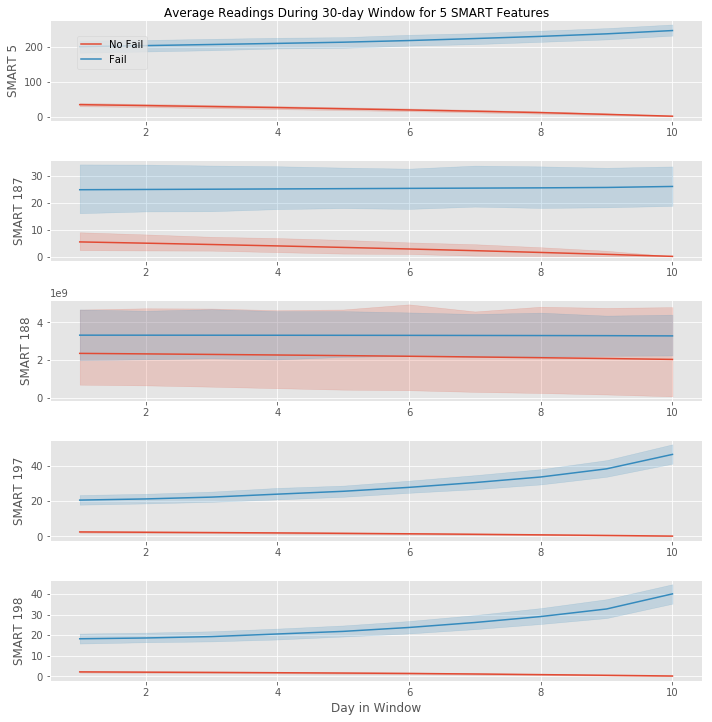

In [5]:
plot_time_series(frame)

**What does this plot tell us?**

There's a lot of interesting conclusions that can be drawn from this plot: 
 + there is a noticeable difference between the average readings for these 5 features for drives that did or did not fail. 
 + the readings for SMART 197 and SMART 198 look nearly identical, this agrees with reporting by BackBlaze.
 + Non failed drives have higher average reading for SMART 188. This *does not* agree with reporting by BackBlaze—these state: from the linked page "when the RAW value for one of these five attributes is greater than zero, we have a reason to investigate". Plot would seem to indicate the opposite for SMART 188

### Samples

Time series look uninteresting for the most part (but this could be due to aggregation, we're only looking at averages). Lets look at individual samples to see if the time series still look uninteresting. This could help inform our modelling approach. 

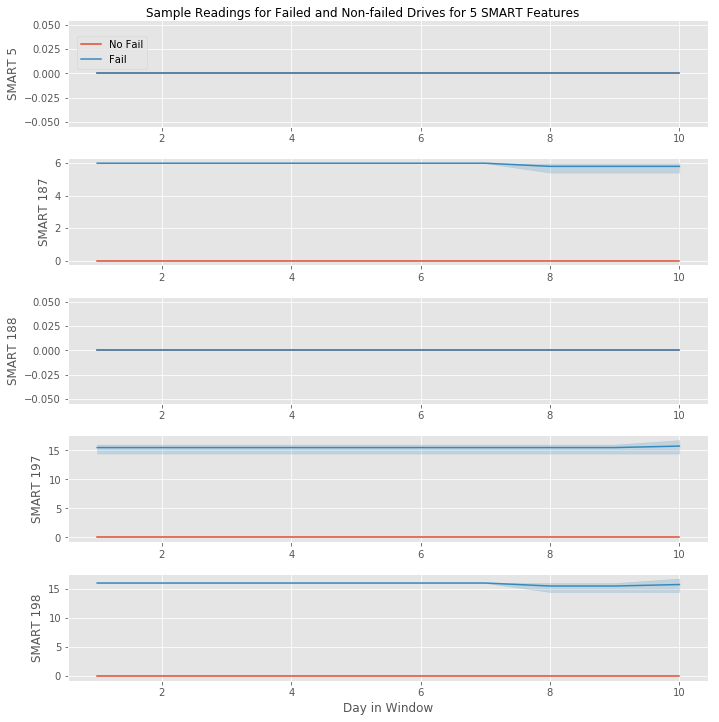

In [6]:
plot_time_series(frame, sample=True)

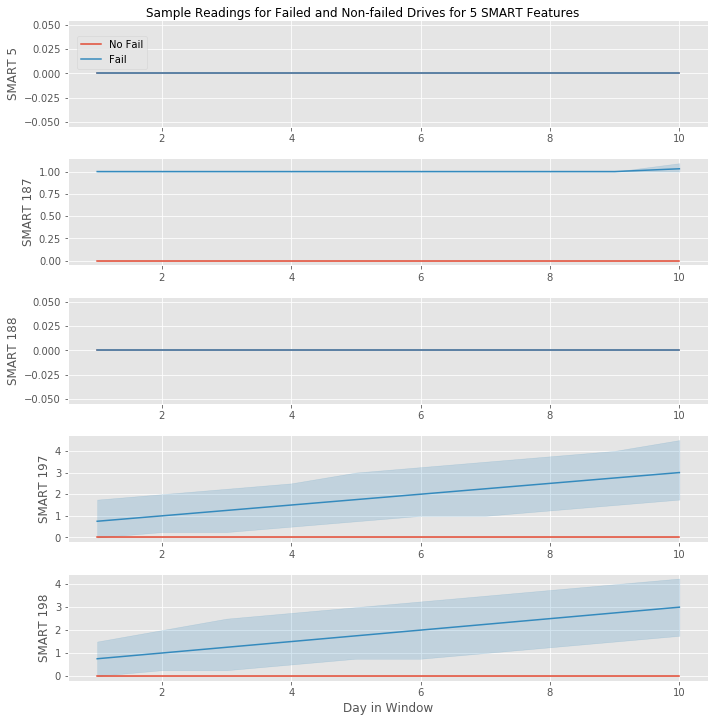

In [7]:
plot_time_series(frame, sample=True)

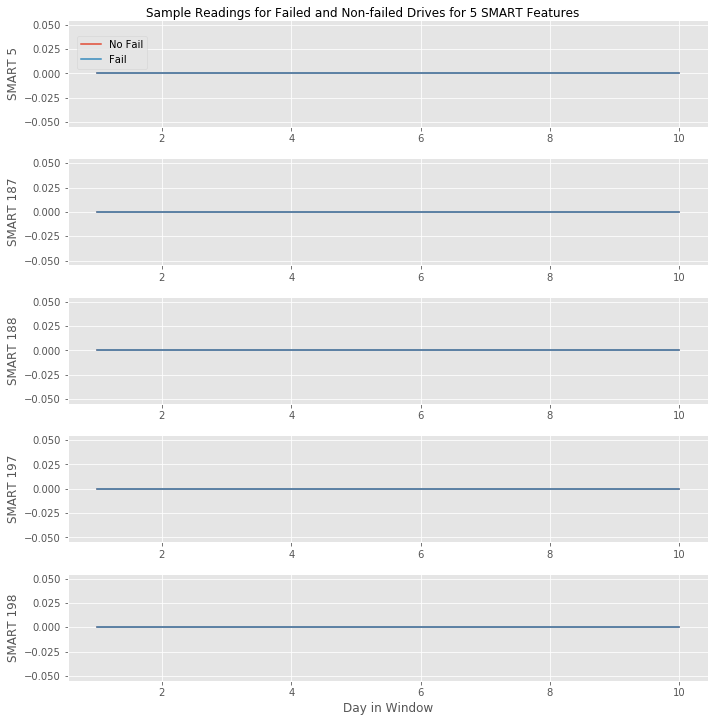

In [8]:
plot_time_series(frame, sample=True)

**NOTE**: Rerun the cells above to see different samples

### Alternative Features

What happens if we do the same plots for some other features? Do we still see a noticeable difference between the two groups?

In [9]:
# From domain knowledge, we know that these 5 features tend to be predictive of failure
new_features = ['smart_12_raw', 'smart_189_raw', 'smart_190_raw', 'smart_193_raw', \
                        'smart_199_raw', 'smart_240_raw', 'smart_242_raw']
new_labels = make_labels(new_features)

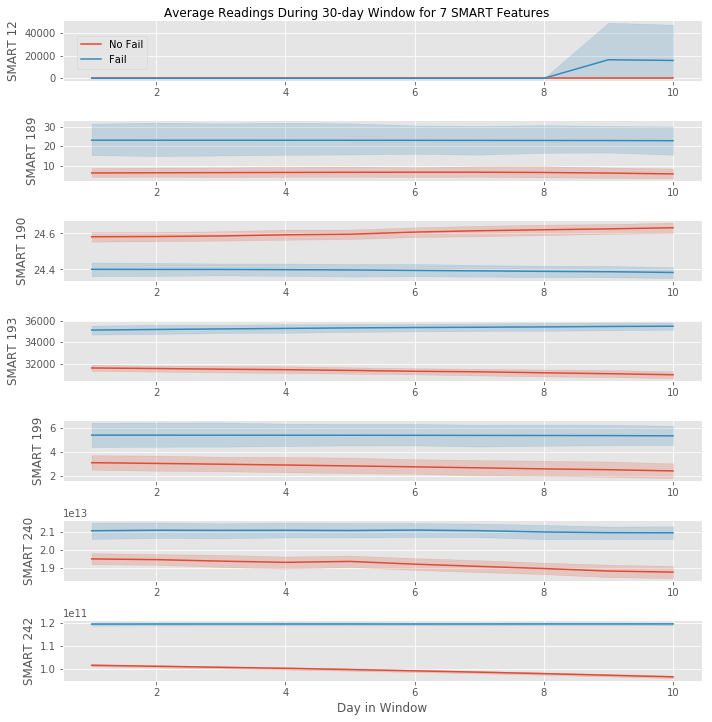

In [10]:
plot_time_series(frame, features=new_features, labels=new_labels)

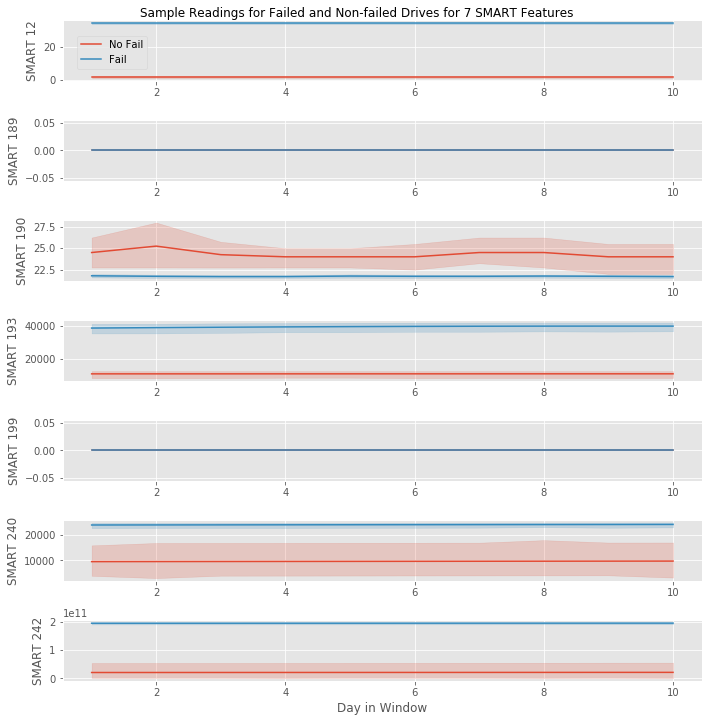

In [11]:
plot_time_series(frame, features=new_features, labels=new_labels, sample=True)

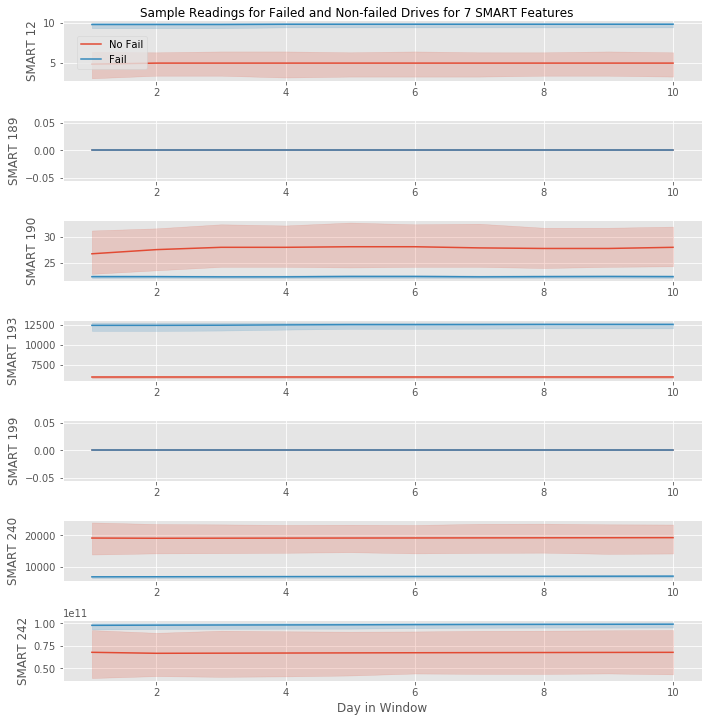

In [12]:
plot_time_series(frame, features=new_features, labels=new_labels, sample=True)

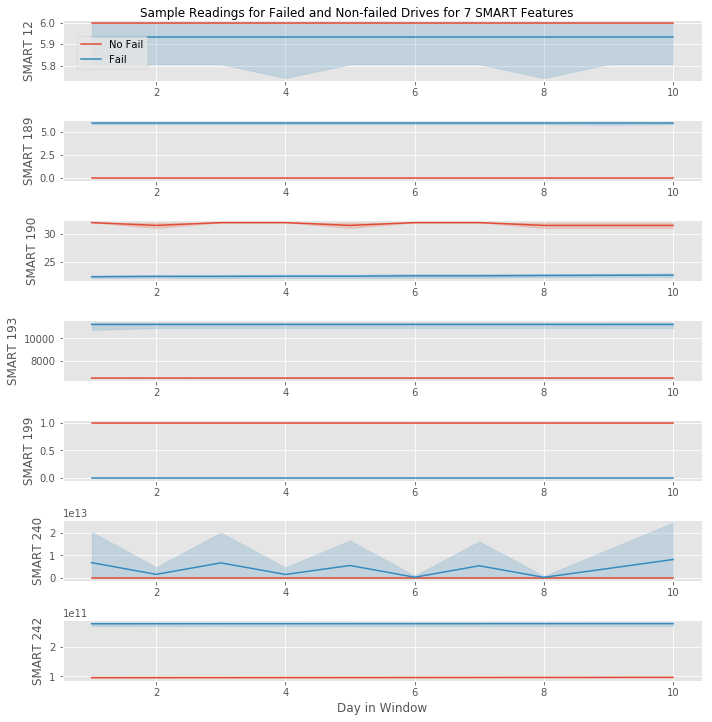

In [13]:
plot_time_series(frame, features=new_features, labels=new_labels, sample=True)